1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

N=20000
data_tot=pd.read_csv('data/data_000637.txt',sep=",")
data_tot=pd.DataFrame(data_tot)
data=data_tot.loc[0:N]
print(data)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
19996     1     0           63  3869200366        2517         6
19997     1     0           32  3869200366        2519         5
19998     1     0           17  3869200366        2522        21
19999     1     0           64  3869200366        2522         0
20000     1     0           23  3869200366        2512        27

[20001 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [2]:
x=data['BX_COUNTER'].max()
print("Estimated number of BX in a ORBIT: ",x)

Estimated number of BX in a ORBIT:  3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [3]:
start=(x*data.loc[0,'ORBIT_CNT']+data.loc[0,'BX_COUNTER'])*25+(25/30)*data.loc[0,'TDC_MEAS']
data['TIME_ns']=(x*data['ORBIT_CNT']+data['BX_COUNTER'])*25+(25/30)*data['TDC_MEAS']-start
TimeSr=pd.to_timedelta(data['TIME_ns'])
print(data)
print(TimeSr)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS       TIME_ns
0         1     0          123  3869200167        2374        26  0.000000e+00
1         1     0          124  3869200167        2374        27  8.125000e-01
2         1     0           63  3869200167        2553        28  4.476625e+03
3         1     0           64  3869200167        2558        19  4.594125e+03
4         1     0           64  3869200167        2760        25  9.649125e+03
...     ...   ...          ...         ...         ...       ...           ...
19996     1     0           63  3869200366        2517         6  1.772948e+07
19997     1     0           32  3869200366        2519         5  1.772953e+07
19998     1     0           17  3869200366        2522        21  1.772962e+07
19999     1     0           64  3869200366        2522         0  1.772960e+07
20000     1     0           23  3869200366        2512        27  1.772938e+07

[20001 rows x 7 columns]
0                 0 days 0

<ipython-input-3-f009f54276e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TIME_ns']=(x*data['ORBIT_CNT']+data['BX_COUNTER'])*25+(25/30)*data['TDC_MEAS']-start


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [4]:
data_tot['TIME_ns']=(x*data_tot['ORBIT_CNT']+data_tot['BX_COUNTER'])*25+(25/30)*data_tot['TDC_MEAS']
TimeSr_tot=pd.to_timedelta(data_tot['TIME_ns'])
print(TimeSr_tot)

0         3 days 23:44:09.004934896
1         3 days 23:44:09.004934897
2         3 days 23:44:09.004939373
3         3 days 23:44:09.004939490
4         3 days 23:44:09.004944545
                     ...           
1310715   3 days 23:44:09.985075886
1310716   3 days 23:44:09.985075909
1310717   3 days 23:44:09.985075925
1310718   3 days 23:44:09.985076050
1310719   3 days 23:44:09.985075890
Name: TIME_ns, Length: 1310720, dtype: timedelta64[ns]


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [5]:
tdc_counts=data_tot.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
tdc_counts=tdc_counts.sort_values(ascending=False)
print('Top 3 noisy channels: \n'+ str(tdc_counts.iloc[0:3]))

Top 3 noisy channels: 
TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [6]:
orb_non_empty=data_tot['ORBIT_CNT'].nunique()
print('Number of non-empty orbits: ',orb_non_empty)

Number of non-empty orbits:  11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [7]:
orb=data_tot.query('TDC_CHANNEL==139')
n_orb=orb['ORBIT_CNT'].nunique()
print('Number of unique orbits with TDC_CHANNEL=139: ',n_orb)

Number of unique orbits with TDC_CHANNEL=139:  10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [8]:
fpga0=data_tot.query('FPGA==0')
fpga1=data_tot.query('FPGA==1')

sr0=fpga0.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
sr1=fpga1.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()

index0=np.array(sr0.index)
index1=np.array(sr1.index)

value0=np.array(sr0.values)
value1=np.array(sr1.values)

sr0=pd.Series(value0, index=index0)
sr1=pd.Series(value1, index=index1)

print('FPGA=0\n',sr0)
print('FPGA=1\n',sr1)

FPGA=0
 1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Length: 124, dtype: int64
FPGA=1
 1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

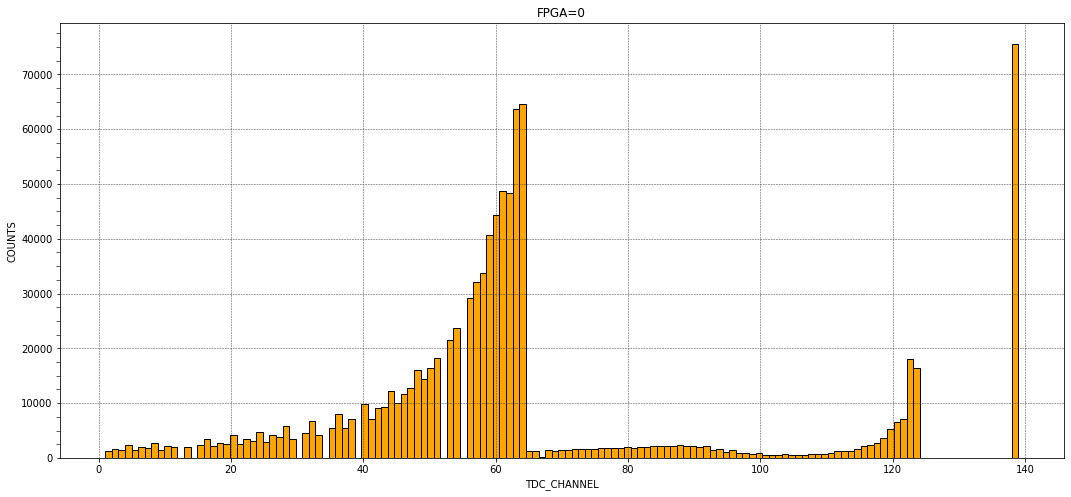

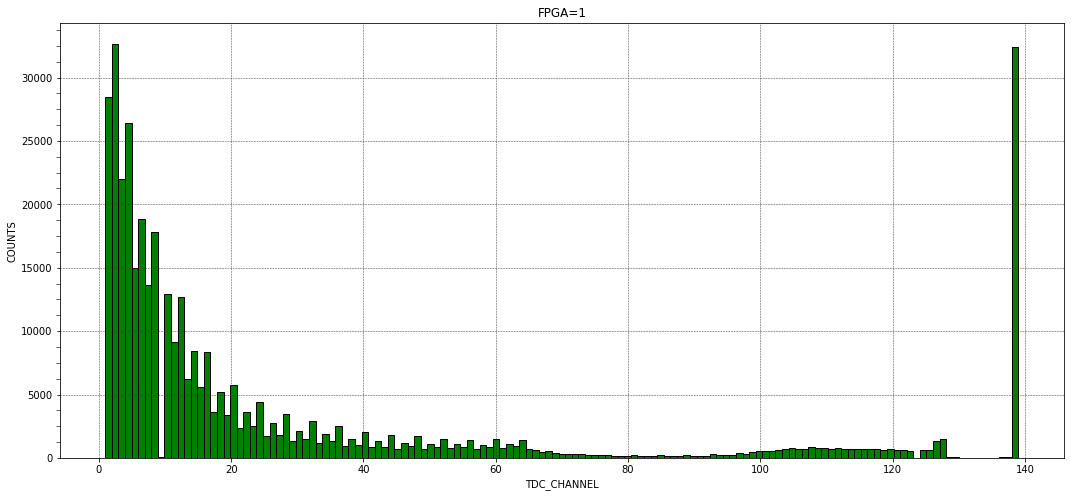

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

fig = plt.figure(figsize=(18, 8)) 
h, bins, _ = plt.hist(fpga0['TDC_CHANNEL'],color='orange', edgecolor='black',bins=139)
ax = fig.axes[0]
ax.set_title('FPGA=0')
ax.set_xlabel('TDC_CHANNEL')
ax.set_ylabel('COUNTS')
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(which='minor', length=4)
ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

fig1 = plt.figure(figsize=(18, 8)) 
h, bins, _ = plt.hist(fpga1['TDC_CHANNEL'],color='green', edgecolor='black',bins=139)
ax1 = fig1.axes[0]
ax1.set_title('FPGA=1')
ax1.set_xlabel('TDC_CHANNEL')
ax1.set_ylabel('COUNTS')
ax1.yaxis.set_minor_locator(AutoMinorLocator(4))
ax1.tick_params(which='minor', length=4)
ax1.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)